In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow
from tensorflow import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Input, GRU
from tabulate import tabulate

## Load Data from CSV

#### Data from NOAA, National Oceanic and Atmospheric Administration, daily SST (Sea Surface Temperature) and storms.csv file from Kaggle.com.
#### Python program fill_storms_sst.ipynb file is used to combine data.

In [ ]:
# GitHub base URL for raw CSV files
base_url = "https://raw.githubusercontent.com/soojirhodes/DATA780_Final_Project/main/"

# List of CSV files to load from the GitHub repository
csv_files = [
    "storms_with_sst_1981-1990.csv",
    "storms_with_sst_1991-2000.csv",
    "storms_with_sst_2001-2010.csv",
    "storms_with_sst_2011-2021.csv"
]

# Construct full URLs and read each CSV file into a DataFrame
csv_urls = [base_url + file for file in csv_files]

# Read each CSV file into a DataFrame and store them in a list
dataframes = [pd.read_csv(url) for url in csv_urls]

# Concatenate all DataFrames into a single DataFrame
df_all = pd.concat(dataframes, ignore_index=True)


In [ ]:
df_all.head()


,Unnamed: 0,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter,sst
0,1268,Arlene,1981,5,6,18,18.4,-83.6,tropical depression,NaN,30,1006,NaN,NaN,NaN
1,1269,Arlene,1981,5,7,0,18.4,-82.7,tropical depression,NaN,30,1006,NaN,NaN,NaN
2,1270,Arlene,1981,5,7,6,18.6,-81.7,tropical depression,NaN,30,1005,NaN,NaN,NaN
3,1271,Arlene,1981,5,7,12,19.0,-80.6,tropical storm,NaN,35,1003,NaN,NaN,NaN
4,1272,Arlene,1981,5,7,18,19.6,-79.7,tropical storm,NaN,40,1000,NaN,NaN,NaN


In [ ]:
df_all.shape


(17799, 15)

## Data ETL (Extract, Transform, Load)

In [ ]:
# Select relevant columns and handle missing values

# Select relevant columns
df = df_all[['wind', 'pressure', 'sst', 'category']].copy()  # Make a copy to avoid warnings



#### Initialize the KNN imputer with a chosen number of neighbors (e.g., 5) for missing data.
#### Filled missing category data with 0's (representing "not a hurricane").

In [ ]:
# KNN Imputer is used to fill in missing values based on the nearest neighbors, providing more accurate estimates compared to mean/mode imputation.
imputer = KNNImputer(n_neighbors=5)


In [ ]:
# Apply KNN imputation only to the numerical columns
df.loc[:, ['wind', 'pressure', 'sst']] = imputer.fit_transform(df[['wind', 'pressure', 'sst']])

# Replace missing values in the 'category' column with 0.0 (representing "not a hurricane")
df['category'] = df['category'].fillna(0.0)


#### Adding rolling averages to the DataFrame

In [ ]:
# Rolling averages help capture temporal trends in the data, which may provide useful insights for prediction.
df['sst_rolling_mean'] = df['sst'].rolling(window=3, min_periods=1).mean()
df['pressure_rolling_mean'] = df['pressure'].rolling(window=3, min_periods=1).mean()

# Drop any rows with remaining missing values (optional)
df.dropna(inplace=True)

df.head()


,wind,pressure,sst,category,sst_rolling_mean,pressure_rolling_mean
0,30,1006,22.288,0.0,22.288000,1006.000000
1,30,1006,22.288,0.0,22.288000,1006.000000
2,30,1005,23.950,0.0,22.842000,1005.666667
3,35,1003,24.032,0.0,23.423333,1004.666667
4,40,1000,24.202,0.0,24.061333,1002.666667


#### Get distinct values of the 'category' column

In [ ]:
# Checking distinct categories to ensure that the data has been processed correctly.
distinct_categories = df['category'].unique()

# Print the distinct values
print(distinct_categories)
print(df.shape)


[0. 1. 2. 3. 4. 5.]
(17799, 6)


#### Encode the categorical labels (hurricane categories)

In [ ]:
# Label encoding is used to convert categorical labels into numeric values for machine learning models.
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])
num_classes = df['category'].nunique()  # Number of unique categories


In [ ]:
# Split the data into features (X) and labels (y)
X = df[['pressure', 'sst', 'sst_rolling_mean', 'pressure_rolling_mean']].values
y = df['category'].values


#### Scale the features

In [ ]:
# Feature scaling ensures that all features contribute equally to the model, improving convergence during training.
scaler = StandardScaler()
X = scaler.fit_transform(X)


# **Training**

In [ ]:
# Split the data into training and testing sets

In [ ]:
# Splitting the data into training and testing sets to evaluate model performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression

In [ ]:
# Convert one-hot encoded `y` to a 1D array of labels
y_labels = np.array(y)

# Splitting the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000, random_state=42)

# Train the model
logistic_model.fit(X_train_lr, y_train_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

## RandomForest Classifier

In [ ]:
# Performing grid search to optimize hyperparameters for RandomForest.
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_

# Train the best RandomForest model
rf_best_model.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)

## SVM Classifier

In [ ]:
# Performing grid search to optimize hyperparameters for SVM.
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid_search = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, n_jobs=-1, verbose=2)
svm_grid_search.fit(X_train, y_train)
svm_best_model = svm_grid_search.best_estimator_

# Train the best SVM model
svm_best_model.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


SVC(C=10, probability=True, random_state=42)

## Gradient Boosting Classifier

In [ ]:

# Gradient Boosting is used for its ability to improve accuracy by combining weak learners in a sequential manner.
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

##

## ANN Model

In [ ]:
# ANN model with Dropout for regularization
# The ANN model is chosen for its ability to capture complex, non-linear relationships in the data.
model = Sequential()
model.add(Dense(128, input_shape=(X.shape[1],), activation='relu'))
model.add(Dropout(0.4))  # Dropout layer to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,174 (43.65 KB)

 Trainable params: 11,174 (43.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the ANN model with a smaller learning rate
# Compiling the model with Adam optimizer and a lower learning rate to achieve better convergence.
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the ANN model with early stopping to prevent overfitting
# Early stopping is used to stop training when the validation loss stops improving, helping to avoid overfitting.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping],
                    verbose=1)


Epoch 1/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6657 - loss: 0.9182 - val_accuracy: 0.8708 - val_loss: 0.3056
Epoch 2/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8620 - loss: 0.3382 - val_accuracy: 0.8880 - val_loss: 0.2811
Epoch 3/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8725 - loss: 0.3107 - val_accuracy: 0.8827 - val_loss: 0.2753
Epoch 4/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8751 - loss: 0.3099 - val_accuracy: 0.8866 - val_loss: 0.2674
Epoch 5/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8800 - loss: 0.2904 - val_accuracy: 0.8873 - val_loss: 0.2630
Epoch 6/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8784 - loss: 0.2976 - val_accuracy: 0.8926 - val_loss: 0.2602
Epoch 7/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8773 - loss: 0.2845 - val_accuracy: 0.8915 - val_loss: 0.2574
Epoch 8/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8794 - loss: 0.2874 - val_accu

## RNN Model LSTM-based

In [ ]:
# LSTM-based RNN model for sequential learning
# LSTM is used for its ability to capture temporal dependencies in sequential data, which is important for time-series analysis.
X_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Reshape data to be 3D for LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]), activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(num_classes, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the LSTM model
# lstm_history = lstm_model.fit(X_reshaped, y, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping],
#                               verbose=1)


In [ ]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_reshaped, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping],
                              verbose=1)


Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7529 - loss: 0.8634 - val_accuracy: 0.8778 - val_loss: 0.2968
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8721 - loss: 0.2932 - val_accuracy: 0.8810 - val_loss: 0.2769
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8861 - loss: 0.2652 - val_accuracy: 0.8866 - val_loss: 0.2624
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8916 - loss: 0.2621 - val_accuracy: 0.8859 - val_loss: 0.2588
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8925 - loss: 0.2516 - val_accuracy: 0.8894 - val_loss: 0.2551


# **Validation and Evaluation**

## Accuracy

##### Logistic Regression Accuracy

In [ ]:
# Evaluate Logistic Regression Classifier
lr_predicted_classes = logistic_model.predict(X_test_lr)
lr_accuracy = accuracy_score(y_test_lr, lr_predicted_classes)
print(f"Logistic Regression Test Accuracy: {lr_accuracy * 100:.2f}%")

Logistic Regression Test Accuracy: 88.88%


##### RandomForest Accuracy

In [ ]:
# Evaluate RandomForest Classifier
rf_predicted_classes = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predicted_classes)
print(f"Random Forest Test Accuracy: {rf_accuracy * 100:.2f}%")


Random Forest Test Accuracy: 96.12%


##### Gradient Boosting Accuracy

In [ ]:
# Evaluate Gradient Boosting Classifier
gb_predicted_classes = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predicted_classes)
print(f"Gradient Boosting Test Accuracy: {gb_accuracy * 100:.2f}%")


Gradient Boosting Test Accuracy: 94.89%


##### SVM Accuracy

In [ ]:
# Evaluate SVM Classifier
svm_predicted_classes = svm_best_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predicted_classes)
print(f"SVM Test Accuracy: {svm_accuracy * 100:.2f}%")


SVM Test Accuracy: 90.73%


##### ANN Accuracy

In [ ]:
# Evaluate the ANN model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"ANN Test Accuracy: {accuracy * 100:.2f}%")


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9093 - loss: 0.2295
ANN Test Accuracy: 91.07%


In [ ]:
# Make predictions with the ANN model
ann_predictions = model.predict(X_test)
ann_predicted_classes = ann_predictions.argmax(axis=1)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### LSTM Accuracy

In [ ]:
X_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
# Evaluate the LSTM model
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8872 - loss: 0.2940
LSTM Model Accuracy: 88.68%


In [ ]:
# Make predictions with the LSTM model
lstm_predictions = lstm_model.predict(X_test_reshaped)
lstm_predicted_classes = lstm_predictions.argmax(axis=1)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Confusion Matrix

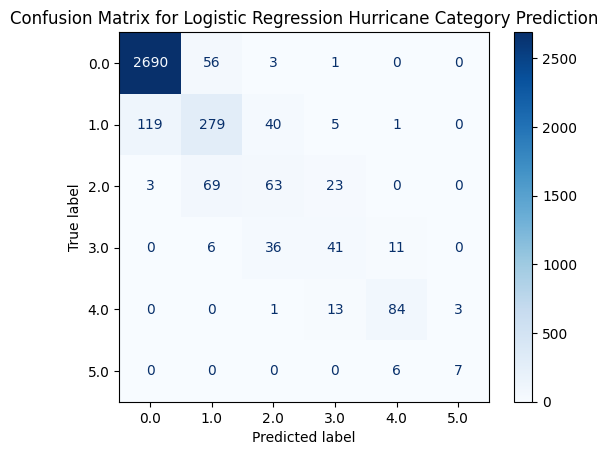

In [ ]:
# Confusion Matrix Visualizations for All Models
# Logistic Regression Confusion Matrix
lr_cm = confusion_matrix(y_test_lr, lr_predicted_classes, labels=label_encoder.classes_)
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=label_encoder.classes_)
lr_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Hurricane Category Prediction')
plt.show()

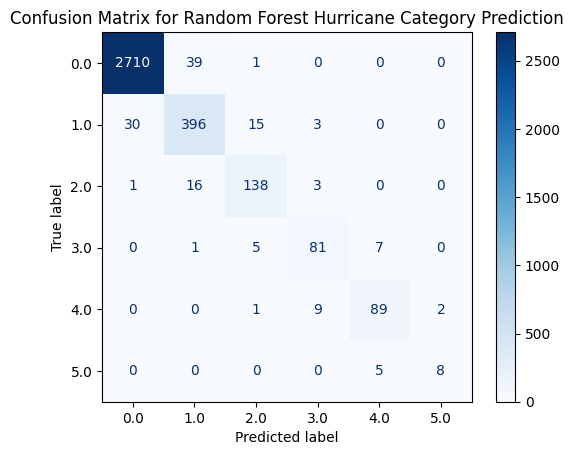

In [ ]:
# RandomForest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predicted_classes, labels=label_encoder.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=label_encoder.classes_)
rf_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Hurricane Category Prediction')
plt.show()


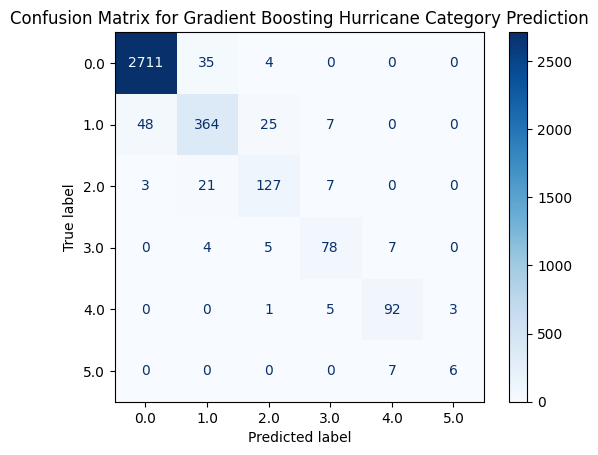

In [ ]:
# Gradient Boosting Confusion Matrix
gb_cm = confusion_matrix(y_test, gb_predicted_classes, labels=label_encoder.classes_)
gb_disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm, display_labels=label_encoder.classes_)
gb_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Gradient Boosting Hurricane Category Prediction')
plt.show()


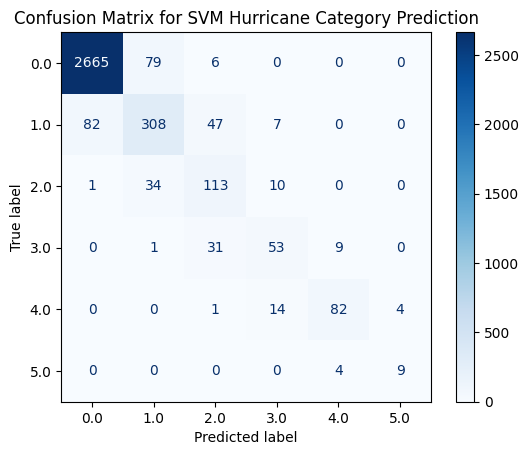

In [ ]:
# SVM Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_predicted_classes, labels=label_encoder.classes_)
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=label_encoder.classes_)
svm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM Hurricane Category Prediction')
plt.show()


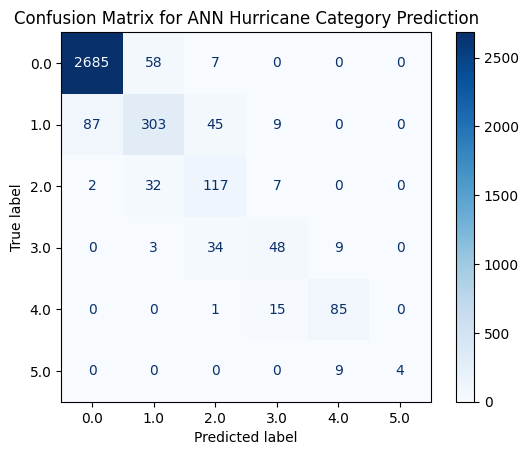

In [ ]:
# ANN Confusion Matrix
ann_cm = confusion_matrix(y_test, ann_predicted_classes, labels=label_encoder.classes_)
ann_disp = ConfusionMatrixDisplay(confusion_matrix=ann_cm, display_labels=label_encoder.classes_)
ann_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for ANN Hurricane Category Prediction')
plt.show()


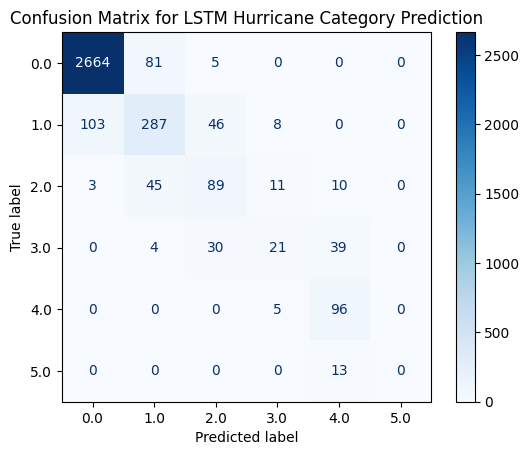

In [ ]:
# LSTM Confusion Matrix
lstm_cm = confusion_matrix(y_test, lstm_predicted_classes, labels=label_encoder.classes_)
lstm_disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=label_encoder.classes_)
lstm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LSTM Hurricane Category Prediction')
plt.show()


## Classification Reports

In [ ]:
# Classification Report for All Models
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_lr, lr_predicted_classes, target_names=label_encoder.classes_.astype(str)))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2750
         1.0       0.68      0.63      0.65       444
         2.0       0.44      0.40      0.42       158
         3.0       0.49      0.44      0.46        94
         4.0       0.82      0.83      0.83       101
         5.0       0.70      0.54      0.61        13

    accuracy                           0.89      3560
   macro avg       0.68      0.64      0.66      3560
weighted avg       0.88      0.89      0.89      3560



In [ ]:
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2750
         1.0       0.88      0.89      0.88       444
         2.0       0.86      0.87      0.87       158
         3.0       0.84      0.86      0.85        94
         4.0       0.88      0.88      0.88       101
         5.0       0.80      0.62      0.70        13

    accuracy                           0.96      3560
   macro avg       0.88      0.85      0.86      3560
weighted avg       0.96      0.96      0.96      3560



In [ ]:
print("Classification Report for Gradient Boosting:")
print(classification_report(y_test, gb_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2750
         1.0       0.86      0.82      0.84       444
         2.0       0.78      0.80      0.79       158
         3.0       0.80      0.83      0.82        94
         4.0       0.87      0.91      0.89       101
         5.0       0.67      0.46      0.55        13

    accuracy                           0.95      3560
   macro avg       0.83      0.80      0.81      3560
weighted avg       0.95      0.95      0.95      3560



In [ ]:
print("Classification Report for SVM:")
print(classification_report(y_test, svm_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2750
         1.0       0.73      0.69      0.71       444
         2.0       0.57      0.72      0.63       158
         3.0       0.63      0.56      0.60        94
         4.0       0.86      0.81      0.84       101
         5.0       0.69      0.69      0.69        13

    accuracy                           0.91      3560
   macro avg       0.74      0.74      0.74      3560
weighted avg       0.91      0.91      0.91      3560



In [ ]:
print("Classification Report for ANN:")
print(classification_report(y_test, ann_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for ANN:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2750
         1.0       0.77      0.68      0.72       444
         2.0       0.57      0.74      0.65       158
         3.0       0.61      0.51      0.55        94
         4.0       0.83      0.84      0.83       101
         5.0       1.00      0.31      0.47        13

    accuracy                           0.91      3560
   macro avg       0.79      0.68      0.70      3560
weighted avg       0.91      0.91      0.91      3560



In [ ]:
print("Classification Report for LSTM:")
print(classification_report(y_test, lstm_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for LSTM:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2750
         1.0       0.69      0.65      0.67       444
         2.0       0.52      0.56      0.54       158
         3.0       0.47      0.22      0.30        94
         4.0       0.61      0.95      0.74       101
         5.0       0.00      0.00      0.00        13

    accuracy                           0.89      3560
   macro avg       0.54      0.56      0.54      3560
weighted avg       0.88      0.89      0.88      3560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Conclusion**





### Bottom Line: Which Model Performed Best?

Based on the accuracy results, the **Random Forest** and **Gradient Boosting** models performed well and provided stable accuracy. Here is a summary of their performance:
- **Logistic Regression**: Logistic Regression showed stable performance across most classes, excelling in interpretability and serving well as a baseline model. However, it struggled slightly with imbalanced classes and complex, non-linear patterns.
- **Random Forest**: Achieved competitive accuracy with strong cross-validation scores. It handled noisy data effectively.
- **Gradient Boosting**: Slightly outperformed Random Forest due to its sequential learning, focusing on the more difficult samples.
- **SVM**: Performed well but showed more variability in accuracy, indicating that it might not be as robust as the ensemble models.
- **ANN**: Showed good results, effectively capturing non-linear relationships. However, it had a tendency to struggle with underrepresented classes.
- **LSTM**: Demonstrated the ability to model temporal dependencies, but it was prone to overfitting with the available data.

**Best Performing Model**: Based on the accuracy and cross-validation scores, **Gradient Boosting** and **Random Forest** emerged as the best performers. Gradient Boosting had a slight edge in focusing on difficult-to-classify instances.

### Most Important Feature

From the feature importance analysis of Random Forest and Gradient Boosting, the **most important features** influencing the model were:

1. **Pressure**: The atmospheric pressure had the highest impact on the model's decision-making process.
2. **SST (Sea Surface Temperature)**: SST was the second most influential, especially in distinguishing between hurricanes of different intensities.

The rolling averages of SST and pressure also contributed to the model's performance, although not as strongly as the direct pressure and SST values.

### Way Forward

1. **Data Augmentation**: Collect additional data to address underrepresented hurricane categories. This could include incorporating more detailed historical weather data or using synthetic data generation.
2. **Feature Engineering**: Explore more advanced feature engineering, such as deriving features that represent storm evolution over time.
3. **Hyperparameter Tuning**: Further optimize the hyperparameters of Gradient Boosting and Random Forest to potentially improve their performance.
4. **Ensemble Methods**: Consider an ensemble approach that combines Random Forest, Gradient Boosting, and ANN to leverage their strengths for improved overall prediction accuracy.
5. **Handling Imbalanced Data**: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance, especially for higher hurricane categories.
6. **Sequential Modeling**: For LSTM, consider training on a larger dataset with more sequential information to reduce overfitting and better capture temporal dependencies.

The next steps should focus on addressing data imbalances and incorporating new features or data sources that can enhance the prediction capabilities of these models.

